# Demo 1: GroupBy Operations

## Learning Objectives
- Master the split-apply-combine paradigm
- Apply aggregation functions to grouped data
- Use transform, filter, and apply operations
- Handle hierarchical grouping

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set inline plotting for Jupyter
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Basic GroupBy Operations

### Create Sample Data

In [2]:
# Create large-scale employee dataset (100,000 rows)
print("=== Creating Large-Scale Employee Dataset ===")
n_employees = 100000

# Generate realistic employee data
departments = [
    "Sales",
    "Engineering",
    "Marketing",
    "HR",
    "Finance",
    "Operations",
]
regions = ["North", "South", "East", "West", "Central"]
employee_names = [f"Emp_{i:05d}" for i in range(n_employees)]

# Create correlated data: Engineering has higher salaries, Sales varies more
dept_salary_base = {
    "Engineering": 85000,
    "Finance": 75000,
    "Marketing": 65000,
    "Sales": 60000,
    "HR": 55000,
    "Operations": 50000,
}

dept_salary_std = {
    "Engineering": 15000,
    "Finance": 12000,
    "Marketing": 10000,
    "Sales": 20000,  # Higher variance
    "HR": 8000,
    "Operations": 7000,
}

# Generate data
np.random.seed(42)
departments_list = np.random.choice(departments, n_employees)
regions_list = np.random.choice(regions, n_employees)

# Create correlated salaries based on department
salaries = []
for dept in departments_list:
    base = dept_salary_base[dept]
    std = dept_salary_std[dept]
    salary = np.random.normal(base, std)
    salaries.append(max(30000, salary))  # Minimum wage floor

# Experience correlates with salary (but with noise)
experience = []
for salary in salaries:
    # More experienced employees tend to earn more, but with variation
    exp_base = (salary - 40000) / 8000
    exp = max(0, int(np.random.normal(exp_base, 2)))
    experience.append(min(exp, 30))  # Cap at 30 years

# Create DataFrame
# Use random dates within a reasonable range to avoid datetime overflow
start_date = pd.Timestamp("2010-01-01")
end_date = pd.Timestamp("2024-01-01")
date_range_days = (end_date - start_date).days
random_days = np.random.randint(0, date_range_days, n_employees)
join_dates = [start_date + pd.Timedelta(days=int(d)) for d in random_days]

df = pd.DataFrame({
    "Employee": employee_names,
    "Department": departments_list,
    "Region": regions_list,
    "Salary": np.round(salaries, 2),
    "Experience": experience,
    "Join_Date": join_dates,
})

# Add some additional features
df["Years_At_Company"] = (pd.Timestamp.now() - df["Join_Date"]).dt.days / 365.25
df["Performance_Score"] = np.random.uniform(1, 5, n_employees)
df["Bonus"] = df["Salary"] * df["Performance_Score"] * 0.1

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

=== Creating Large-Scale Employee Dataset ===


Dataset shape: (100000, 9)
Memory usage: 20.63 MB

First few rows:
    Employee Department   Region    Salary  Experience  Join_Date  \
0  Emp_00000         HR  Central  61172.56           2 2018-01-15   
1  Emp_00001    Finance  Central  73403.03           4 2012-09-17   
2  Emp_00002  Marketing    South  68672.05           1 2013-02-08   
3  Emp_00003    Finance  Central  62785.89           3 2017-01-25   
4  Emp_00004    Finance     East  53152.50           1 2016-12-07   

   Years_At_Company  Performance_Score         Bonus  
0          7.822040           4.192346  25645.651138  
1         13.149897           4.569293  33539.991617  
2         12.755647           2.239184  15376.935107  
3          8.793977           1.826578  11468.335462  
4          8.928131           2.428118  12906.053432  

Basic statistics:
              Salary     Experience                      Join_Date  \
count  100000.000000  100000.000000                         100000   
mean    65185.978293       2.

### Basic Aggregation

=== Basic Aggregation ===
Mean salary by department:
Department
Engineering    85162.199645
Finance        75096.724912
HR             55015.715961
Marketing      64863.975714
Operations     50099.663724
Sales          60644.296774
Name: Salary, dtype: float64

=== Comprehensive Department Statistics ===
                   Salary                                                      \
                     mean    median           std       min        max  count   
Department                                                                      
Engineering  85162.199645  85052.56  14854.458581  31000.38  147085.06  16799   
Finance      75096.724912  75098.34  11986.356194  30000.00  122822.63  16810   
HR           55015.715961  55012.67   7983.256202  30000.00   85706.26  16776   
Marketing    64863.975714  64869.23   9995.505377  30000.00  103719.69  16390   
Operations   50099.663724  50130.44   6965.723655  30000.00   76578.66  16633   
Sales        60644.296774  60071.63  18670.589

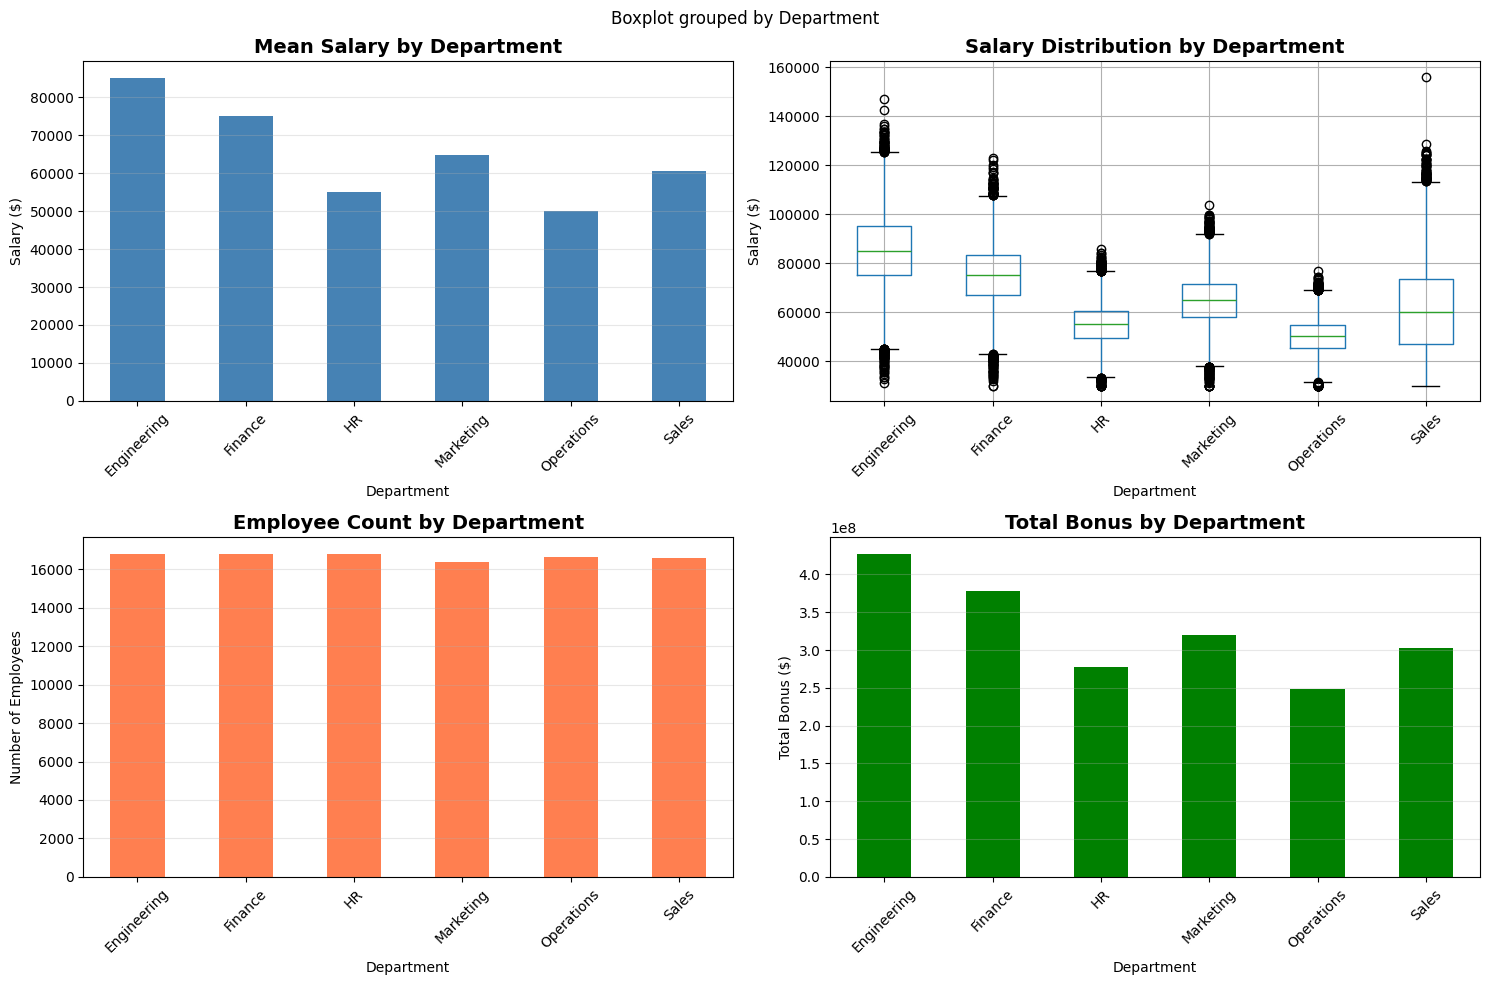

In [3]:
# Group by department and calculate comprehensive statistics
print("=== Basic Aggregation ===")
print("Mean salary by department:")
dept_salary_mean = df.groupby("Department")["Salary"].mean()
print(dept_salary_mean)

print("\n=== Comprehensive Department Statistics ===")
dept_stats = df.groupby("Department").agg({
    "Salary": ["mean", "median", "std", "min", "max", "count"],
    "Experience": ["mean", "max"],
    "Performance_Score": "mean",
    "Bonus": "sum",
})
print(dept_stats)

# Visualize department statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Mean salary by department
dept_salary_mean.plot(kind="bar", ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title(
    "Mean Salary by Department", fontsize=14, fontweight="bold"
)
axes[0, 0].set_ylabel("Salary ($)")
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 0].grid(axis="y", alpha=0.3)

# 2. Salary distribution by department (box plot)
df.boxplot(column="Salary", by="Department", ax=axes[0, 1])
axes[0, 1].set_title(
    "Salary Distribution by Department", fontsize=14, fontweight="bold"
)
axes[0, 1].set_xlabel("Department")
axes[0, 1].set_ylabel("Salary ($)")
axes[0, 1].tick_params(axis="x", rotation=45)

# 3. Employee count by department
dept_counts = df["Department"].value_counts().sort_index()
dept_counts.plot(kind="bar", ax=axes[1, 0], color="coral")
axes[1, 0].set_title(
    "Employee Count by Department", fontsize=14, fontweight="bold"
)
axes[1, 0].set_ylabel("Number of Employees")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(axis="y", alpha=0.3)

# 4. Total bonus by department
dept_bonus = df.groupby("Department")["Bonus"].sum()
dept_bonus.plot(kind="bar", ax=axes[1, 1], color="green")
axes[1, 1].set_title(
    "Total Bonus by Department", fontsize=14, fontweight="bold"
)
axes[1, 1].set_ylabel("Total Bonus ($)")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### GroupBy with Multiple Columns

=== Multi-column Grouping: Department × Region ===
                           Salary                     Experience  \
                             mean           std count       mean   
Department  Region                                                 
Engineering Central  84990.792053  14929.027335  3322   5.148405   
            East     85234.016283  15099.749337  3414   5.230521   
            North    85061.971605  14843.391404  3277   5.157156   
            South    85094.498726  14694.882937  3421   5.144402   
            West     85424.988993  14705.999460  3365   5.280535   
Finance     Central  75262.171111  12015.474275  3374   3.939538   
            East     75181.267670  11929.947760  3365   3.944428   
            North    75311.098955  11944.163077  3369   4.041555   
            South    74690.234367  11960.908523  3341   3.922179   
            West     75035.182782  12077.331624  3361   3.927403   
HR          Central  54967.822111   8066.340936  3378   1.770278 

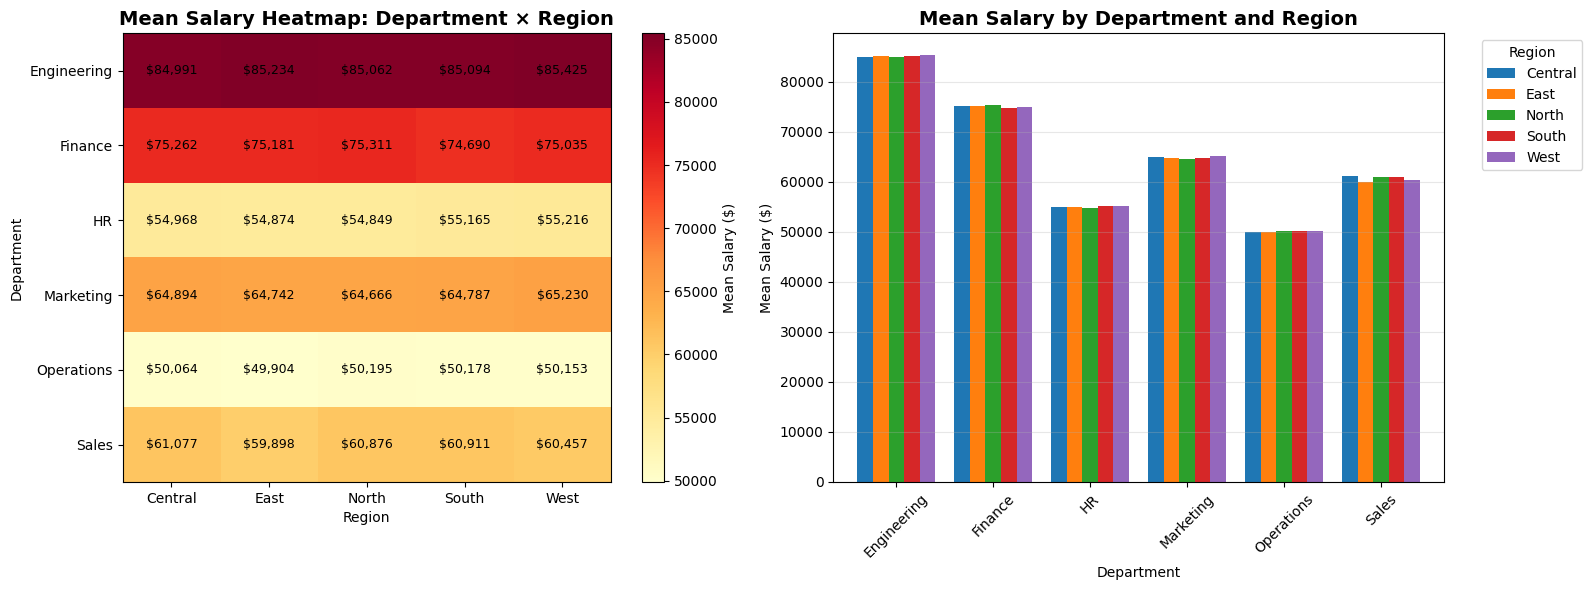

In [4]:
# Group by multiple columns - Department and Region
print("=== Multi-column Grouping: Department × Region ===")
result = df.groupby(["Department", "Region"]).agg({
    "Salary": ["mean", "std", "count"],
    "Experience": "mean",
    "Performance_Score": "mean",
    "Bonus": "sum",
})
print(result.head(20))

# Visualize multi-dimensional grouping
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Heatmap of mean salary by Department × Region
salary_pivot = df.groupby(["Department", "Region"])["Salary"].mean().unstack()
im = axes[0].imshow(salary_pivot.values, cmap="YlOrRd", aspect="auto")
axes[0].set_xticks(range(len(salary_pivot.columns)))
axes[0].set_yticks(range(len(salary_pivot.index)))
axes[0].set_xticklabels(salary_pivot.columns)
axes[0].set_yticklabels(salary_pivot.index)
axes[0].set_title(
    "Mean Salary Heatmap: Department × Region", fontsize=14, fontweight="bold"
)
axes[0].set_xlabel("Region")
axes[0].set_ylabel("Department")
plt.colorbar(im, ax=axes[0], label="Mean Salary ($)")

# Add text annotations
for i in range(len(salary_pivot.index)):
    for j in range(len(salary_pivot.columns)):
        text = axes[0].text(
            j,
            i,
            f"${salary_pivot.iloc[i, j]:,.0f}",
            ha="center",
            va="center",
            color="black",
            fontsize=9,
        )

# 2. Grouped bar chart
dept_region_salary = (
    df.groupby(["Department", "Region"])["Salary"].mean().unstack()
)
dept_region_salary.plot(kind="bar", ax=axes[1], width=0.8)
axes[1].set_title(
    "Mean Salary by Department and Region", fontsize=14, fontweight="bold"
)
axes[1].set_ylabel("Mean Salary ($)")
axes[1].set_xlabel("Department")
axes[1].legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Advanced GroupBy Operations

### Transform Operations

=== Transform Operations ===
Adding department-level statistics to each employee record...
Sample of transformed data:
    Department   Employee    Salary  Dept_Salary_Mean  Dept_Salary_Std  \
0           HR  Emp_00000  61172.56      55015.715961      7983.256202   
1      Finance  Emp_00001  73403.03      75096.724912     11986.356194   
2    Marketing  Emp_00002  68672.05      64863.975714      9995.505377   
3      Finance  Emp_00003  62785.89      75096.724912     11986.356194   
4      Finance  Emp_00004  53152.50      75096.724912     11986.356194   
5  Engineering  Emp_00005  96130.12      85162.199645     14854.458581   
6    Marketing  Emp_00006  54247.71      64863.975714      9995.505377   
7    Marketing  Emp_00007  56250.63      64863.975714      9995.505377   
8    Marketing  Emp_00008  72438.36      64863.975714      9995.505377   
9      Finance  Emp_00009  40221.25      75096.724912     11986.356194   

   Salary_Normalized  Salary_Z_Score Salary_Percentile_Rank  
0   

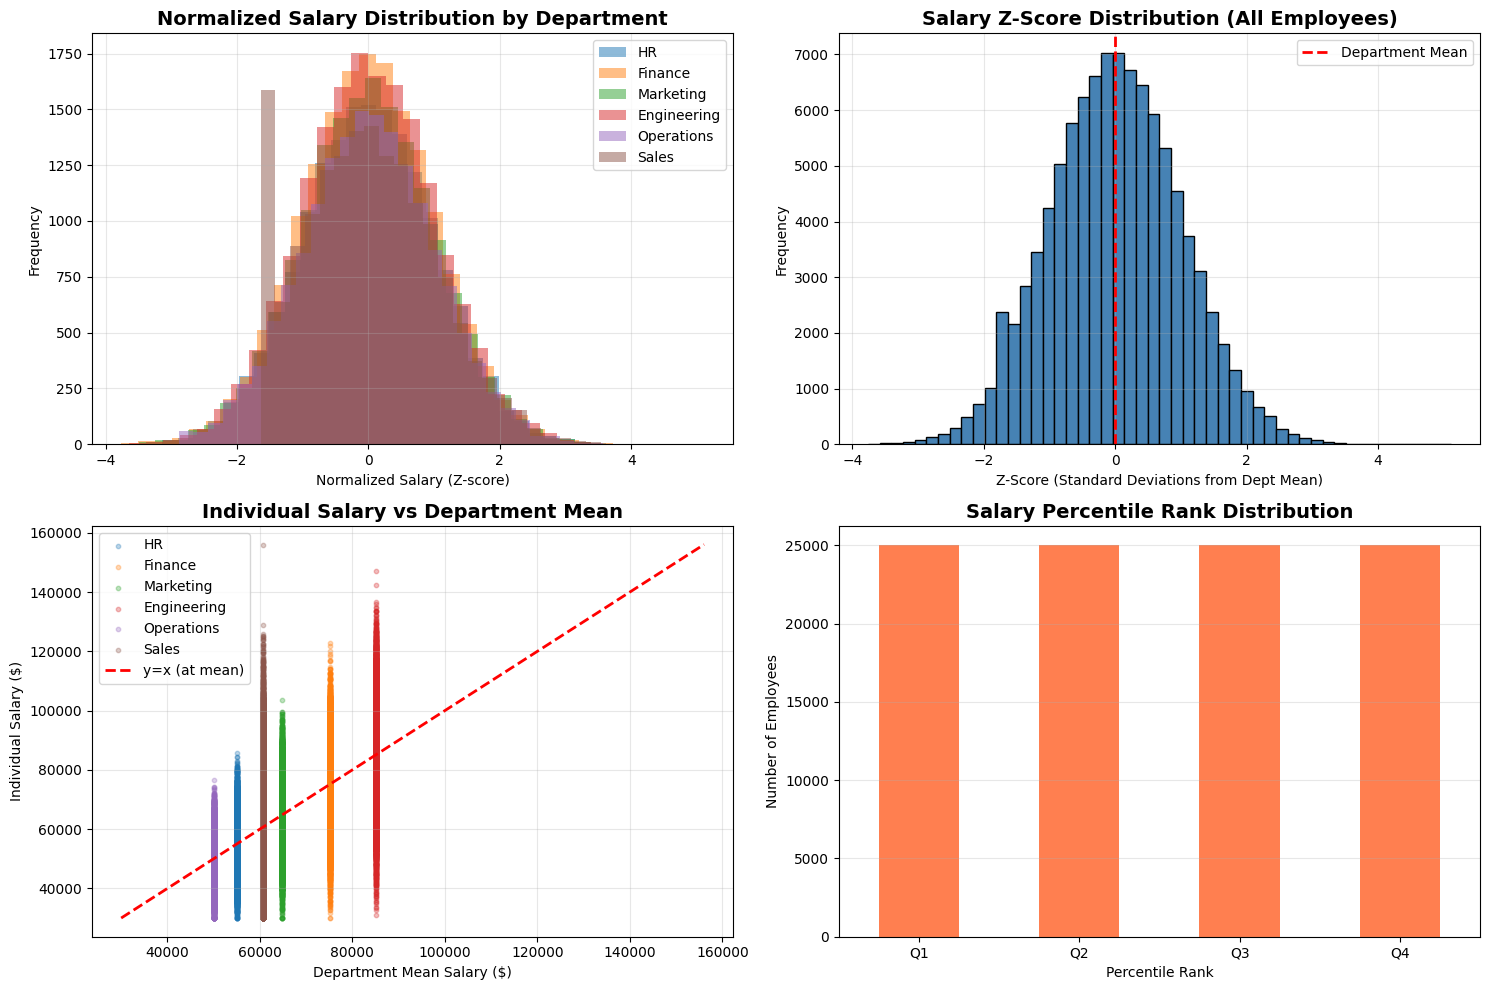

In [5]:
# Transform: Add group statistics as new columns
print("=== Transform Operations ===")
print("Adding department-level statistics to each employee record...")

df["Dept_Salary_Mean"] = df.groupby("Department")["Salary"].transform("mean")
df["Dept_Salary_Std"] = df.groupby("Department")["Salary"].transform("std")
df["Dept_Salary_Median"] = df.groupby("Department")["Salary"].transform(
    "median"
)
df["Salary_Normalized"] = df.groupby("Department")["Salary"].transform(
    lambda x: (x - x.mean()) / x.std()
)
df["Salary_Percentile_Rank"] = df.groupby("Department")["Salary"].transform(
    lambda x: pd.qcut(
        x, q=4, labels=["Q1", "Q2", "Q3", "Q4"], duplicates="drop"
    )
)

# Calculate how many standard deviations each employee is from their department mean
df["Salary_Z_Score"] = (df["Salary"] - df["Dept_Salary_Mean"]) / df[
    "Dept_Salary_Std"
]

print("Sample of transformed data:")
sample_cols = [
    "Department",
    "Employee",
    "Salary",
    "Dept_Salary_Mean",
    "Dept_Salary_Std",
    "Salary_Normalized",
    "Salary_Z_Score",
    "Salary_Percentile_Rank",
]
print(df[sample_cols].head(10))

# Visualize transform results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of normalized salaries by department
for dept in df["Department"].unique():
    dept_data = df[df["Department"] == dept]["Salary_Normalized"]
    axes[0, 0].hist(dept_data, alpha=0.5, label=dept, bins=30)
axes[0, 0].set_title(
    "Normalized Salary Distribution by Department",
    fontsize=14,
    fontweight="bold",
)
axes[0, 0].set_xlabel("Normalized Salary (Z-score)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Z-score distribution
df["Salary_Z_Score"].hist(
    bins=50, ax=axes[0, 1], color="steelblue", edgecolor="black"
)
axes[0, 1].axvline(
    0, color="red", linestyle="--", linewidth=2, label="Department Mean"
)
axes[0, 1].set_title(
    "Salary Z-Score Distribution (All Employees)",
    fontsize=14,
    fontweight="bold",
)
axes[0, 1].set_xlabel("Z-Score (Standard Deviations from Dept Mean)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Salary vs Department Mean (scatter)
for dept in df["Department"].unique():
    dept_data = df[df["Department"] == dept]
    axes[1, 0].scatter(
        dept_data["Dept_Salary_Mean"],
        dept_data["Salary"],
        alpha=0.3,
        label=dept,
        s=10,
    )
axes[1, 0].plot(
    [df["Salary"].min(), df["Salary"].max()],
    [df["Salary"].min(), df["Salary"].max()],
    "r--",
    linewidth=2,
    label="y=x (at mean)",
)
axes[1, 0].set_title(
    "Individual Salary vs Department Mean", fontsize=14, fontweight="bold"
)
axes[1, 0].set_xlabel("Department Mean Salary ($)")
axes[1, 0].set_ylabel("Individual Salary ($)")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Percentile rank distribution
percentile_counts = df["Salary_Percentile_Rank"].value_counts().sort_index()
percentile_counts.plot(kind="bar", ax=axes[1, 1], color="coral")
axes[1, 1].set_title(
    "Salary Percentile Rank Distribution", fontsize=14, fontweight="bold"
)
axes[1, 1].set_xlabel("Percentile Rank")
axes[1, 1].set_ylabel("Number of Employees")
axes[1, 1].tick_params(axis="x", rotation=0)
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Filter Operations

=== Filter Operations ===
Departments with at least 15,000 employees:
Filtered dataset shape: (100000, 15)
Departments kept: ['HR' 'Finance' 'Marketing' 'Engineering' 'Operations' 'Sales']

Departments with average salary > $65,000:
Filtered dataset shape: (33609, 15)
Departments kept: ['Finance' 'Engineering']

Departments with salary std > $12,000:
Filtered dataset shape: (33391, 15)
Departments kept: ['Engineering' 'Sales']


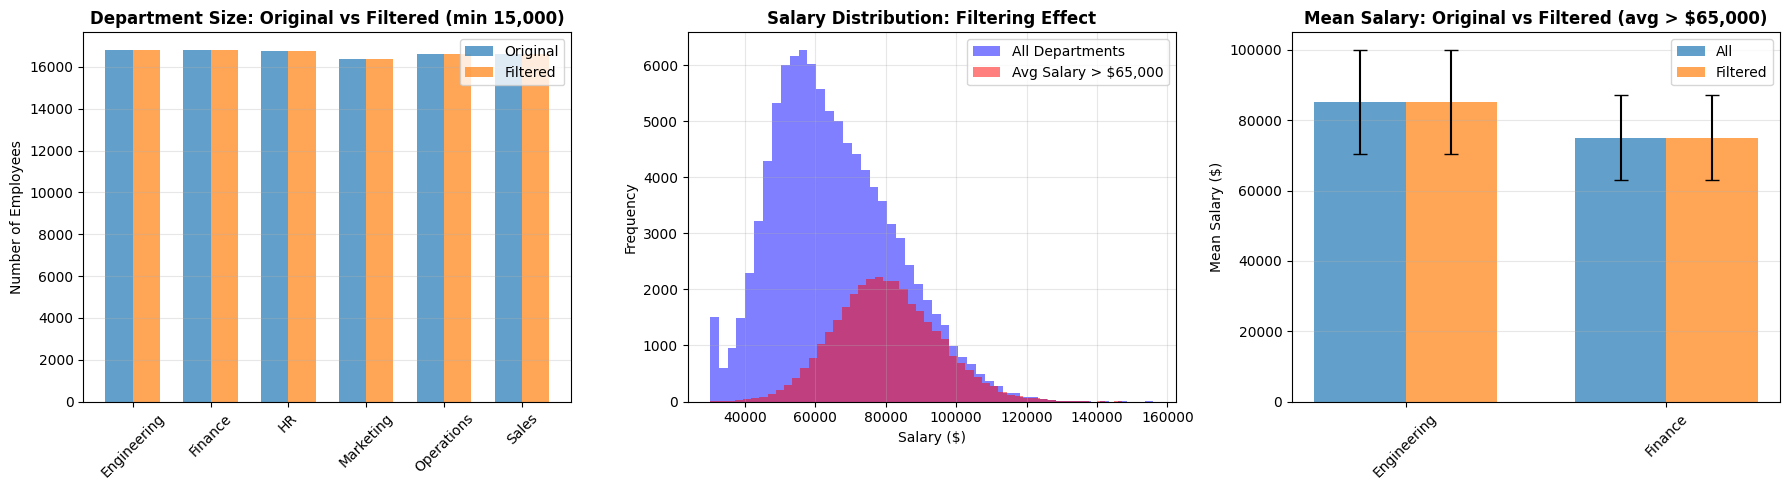

In [6]:
# Filter: Keep only departments with more than threshold employees
print("=== Filter Operations ===")
min_employees = 15000  # Filter departments with at least 15,000 employees
filtered_large_depts = df.groupby("Department").filter(
    lambda x: len(x) >= min_employees
)
print(f"Departments with at least {min_employees:,} employees:")
print(f"Filtered dataset shape: {filtered_large_depts.shape}")
print(f"Departments kept: {filtered_large_depts['Department'].unique()}")

# Filter: Keep only departments with average salary > threshold
salary_threshold = 65000
high_salary_depts = df.groupby("Department").filter(
    lambda x: x["Salary"].mean() > salary_threshold
)
print(f"\nDepartments with average salary > ${salary_threshold:,}:")
print(f"Filtered dataset shape: {high_salary_depts.shape}")
print(f"Departments kept: {high_salary_depts['Department'].unique()}")

# Filter: Keep departments with high variance (interesting for analysis)
high_variance_depts = df.groupby("Department").filter(
    lambda x: x["Salary"].std() > 12000
)
print(f"\nDepartments with salary std > $12,000:")
print(f"Filtered dataset shape: {high_variance_depts.shape}")
print(f"Departments kept: {high_variance_depts['Department'].unique()}")

# Visualize filtering effects
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Department sizes (original vs filtered)
dept_counts_original = df["Department"].value_counts().sort_index()
dept_counts_filtered = (
    filtered_large_depts["Department"].value_counts().sort_index()
)
x_pos = np.arange(len(dept_counts_original.index))
width = 0.35
axes[0].bar(
    x_pos - width / 2,
    dept_counts_original.values,
    width,
    label="Original",
    alpha=0.7,
)
axes[0].bar(
    x_pos + width / 2,
    dept_counts_filtered.values,
    width,
    label="Filtered",
    alpha=0.7,
)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(dept_counts_original.index, rotation=45)
axes[0].set_title(
    f"Department Size: Original vs Filtered (min {min_employees:,})",
    fontsize=12,
    fontweight="bold",
)
axes[0].set_ylabel("Number of Employees")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# 2. Salary distributions: original vs high-salary departments
axes[1].hist(
    df["Salary"], bins=50, alpha=0.5, label="All Departments", color="blue"
)
axes[1].hist(
    high_salary_depts["Salary"],
    bins=50,
    alpha=0.5,
    label=f"Avg Salary > ${salary_threshold:,}",
    color="red",
)
axes[1].set_title(
    "Salary Distribution: Filtering Effect", fontsize=12, fontweight="bold"
)
axes[1].set_xlabel("Salary ($)")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Department salary statistics comparison
dept_stats_all = df.groupby("Department")["Salary"].agg(["mean", "std"])
dept_stats_filtered = high_salary_depts.groupby("Department")["Salary"].agg([
    "mean",
    "std",
])
# Only compare departments that exist in both datasets
common_depts = dept_stats_all.index.intersection(dept_stats_filtered.index)
if len(common_depts) > 0:
    dept_stats_all_subset = dept_stats_all.loc[common_depts]
    dept_stats_filtered_subset = dept_stats_filtered.loc[common_depts]
    x_pos = np.arange(len(common_depts))
    axes[2].bar(
        x_pos - width / 2,
        dept_stats_all_subset["mean"],
        width,
        label="All",
        alpha=0.7,
        yerr=dept_stats_all_subset["std"],
        capsize=5,
    )
    axes[2].bar(
        x_pos + width / 2,
        dept_stats_filtered_subset["mean"],
        width,
        label="Filtered",
        alpha=0.7,
        yerr=dept_stats_filtered_subset["std"],
        capsize=5,
    )
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(common_depts, rotation=45)
else:
    axes[2].text(
        0.5,
        0.5,
        "No common departments\nbetween filtered datasets",
        ha="center",
        va="center",
        transform=axes[2].transAxes,
    )
axes[2].set_title(
    f"Mean Salary: Original vs Filtered (avg > ${salary_threshold:,})",
    fontsize=12,
    fontweight="bold",
)
axes[2].set_ylabel("Mean Salary ($)")
axes[2].legend()
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Apply Operations

=== Apply Operations ===
Comprehensive statistics by department:
               count          mean    median           std       min  \
Department                                                             
Engineering  16799.0  85162.199645  85052.56  14854.458581  31000.38   
Finance      16810.0  75096.724912  75098.34  11986.356194  30000.00   
HR           16776.0  55015.715961  55012.67   7983.256202  30000.00   
Marketing    16390.0  64863.975714  64869.23   9995.505377  30000.00   
Operations   16633.0  50099.663724  50130.44   6965.723655  30000.00   
Sales        16592.0  60644.296774  60071.63  18670.589846  30000.00   

                   max      range         q25        q75         iqr  \
Department                                                             
Engineering  147085.06  116084.68  75141.8500  95237.260  20095.4100   
Finance      122822.63   92822.63  67017.3550  83194.720  16177.3650   
HR            85706.26   55706.26  49543.1675  60368.235  10825.0675  


Top 5 earners per department:
        Department   Employee     Salary  Experience  Performance_Score
67770  Engineering  Emp_67770  147085.06          13           3.266169
45704  Engineering  Emp_45704  142373.27          16           4.125400
40282  Engineering  Emp_40282  136597.74          12           4.923634
13718  Engineering  Emp_13718  136123.98          13           1.443073
52466  Engineering  Emp_52466  134832.30          14           3.249753
43236      Finance  Emp_43236  122822.63           6           1.028100
35949      Finance  Emp_35949  121860.67           9           2.341585
70273      Finance  Emp_70273  120092.29          10           2.439906
4199       Finance  Emp_04199  119169.11           9           2.845420
59440      Finance  Emp_59440  118562.16          11           1.904331
38392           HR  Emp_38392   85706.26           8           1.103068
49390           HR  Emp_49390   84288.10           8           2.643131
80009           HR  Emp_80009   8

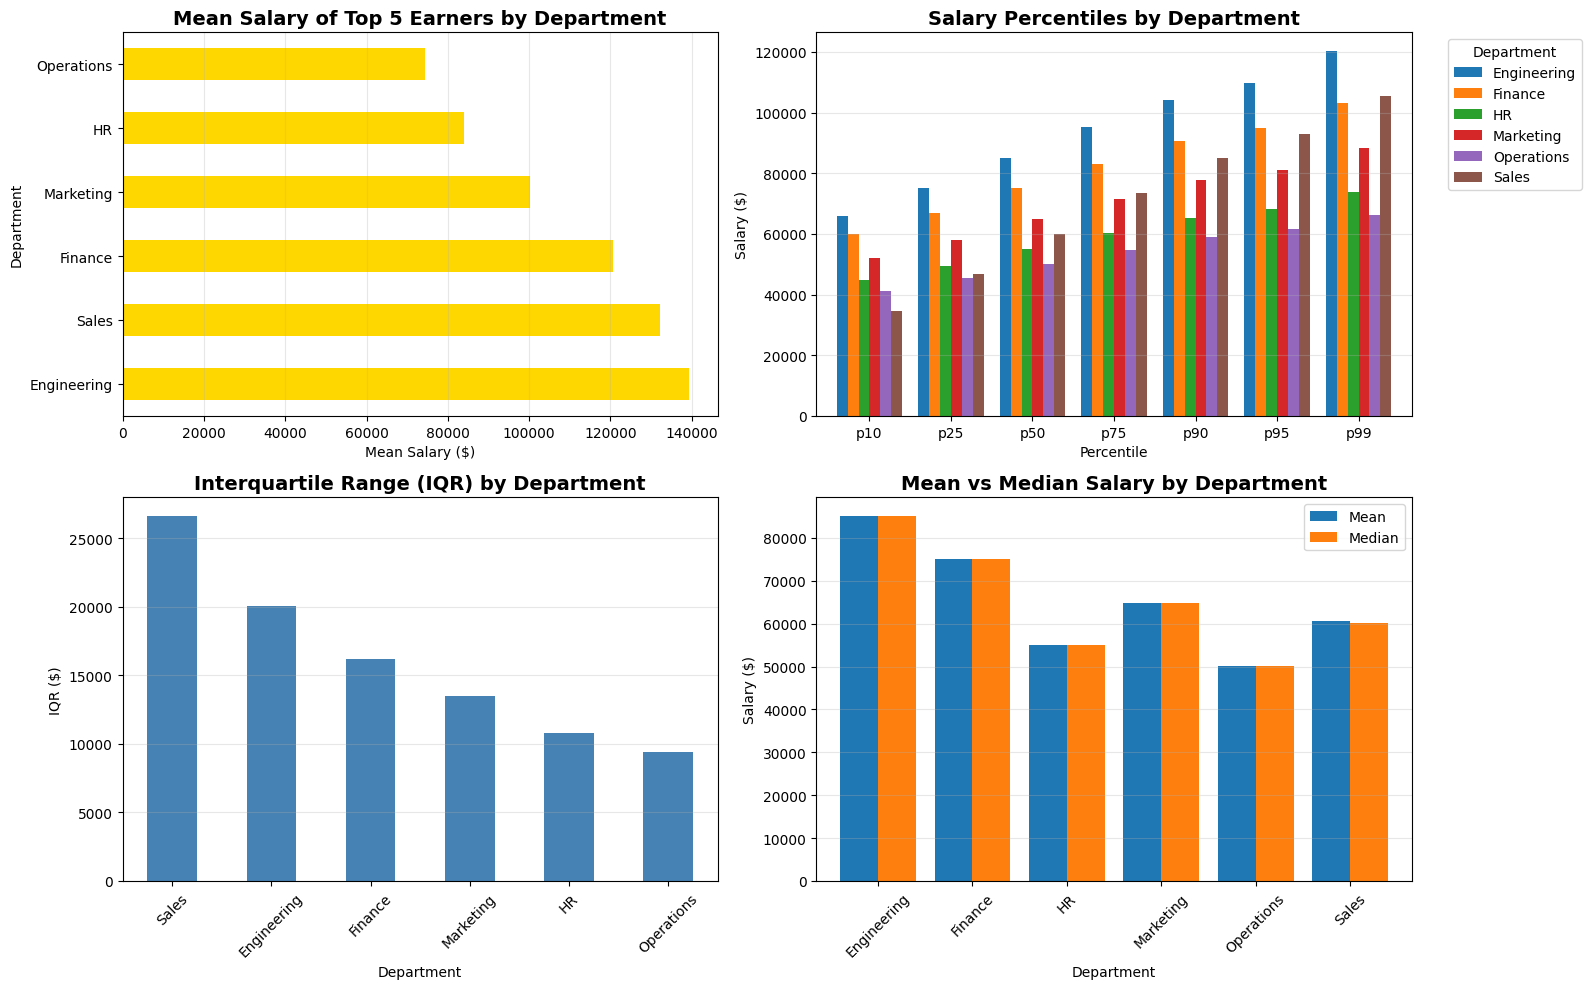

In [7]:
# Apply: Custom function for comprehensive salary statistics
def comprehensive_salary_stats(group):
    """Calculate comprehensive statistics for a group"""
    return pd.Series({
        "count": len(group),
        "mean": group["Salary"].mean(),
        "median": group["Salary"].median(),
        "std": group["Salary"].std(),
        "min": group["Salary"].min(),
        "max": group["Salary"].max(),
        "range": group["Salary"].max() - group["Salary"].min(),
        "q25": group["Salary"].quantile(0.25),
        "q75": group["Salary"].quantile(0.75),
        "iqr": group["Salary"].quantile(0.75) - group["Salary"].quantile(0.25),
        "mean_experience": group["Experience"].mean(),
        "mean_performance": group["Performance_Score"].mean(),
    })


print("=== Apply Operations ===")
print("Comprehensive statistics by department:")
dept_stats_apply = df.groupby("Department").apply(
    comprehensive_salary_stats, include_groups=False
)
print(dept_stats_apply)

# Apply: Get top N earners in each department
top_n = 5
top_earners = df.groupby("Department").apply(
    lambda x: x.nlargest(top_n, "Salary"), include_groups=False
)
print(f"\nTop {top_n} earners per department:")
# Department is in the index, so we need to reset it or access it differently
top_earners_display = top_earners.reset_index(level=0, drop=False)
print(
    top_earners_display[
        ["Department", "Employee", "Salary", "Experience", "Performance_Score"]
    ]
)


# Apply: Calculate department-specific percentiles
def calculate_percentiles(group):
    """Calculate salary percentiles for a group"""
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    return pd.Series({
        f"p{p}": group["Salary"].quantile(p / 100) for p in percentiles
    })


dept_percentiles = df.groupby("Department").apply(
    calculate_percentiles, include_groups=False
)
print("\nSalary percentiles by department:")
print(dept_percentiles)

# Visualize apply results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Top earners visualization
top_earners_plot = (
    top_earners_display.groupby("Department")["Salary"]
    .mean()
    .sort_values(ascending=False)
)
top_earners_plot.plot(kind="barh", ax=axes[0, 0], color="gold")
axes[0, 0].set_title(
    f"Mean Salary of Top {top_n} Earners by Department",
    fontsize=14,
    fontweight="bold",
)
axes[0, 0].set_xlabel("Mean Salary ($)")
axes[0, 0].grid(axis="x", alpha=0.3)

# 2. Percentile comparison across departments
dept_percentiles.T.plot(kind="bar", ax=axes[0, 1], width=0.8)
axes[0, 1].set_title(
    "Salary Percentiles by Department", fontsize=14, fontweight="bold"
)
axes[0, 1].set_ylabel("Salary ($)")
axes[0, 1].set_xlabel("Percentile")
axes[0, 1].legend(
    title="Department", bbox_to_anchor=(1.05, 1), loc="upper left"
)
axes[0, 1].tick_params(axis="x", rotation=0)
axes[0, 1].grid(axis="y", alpha=0.3)

# 3. IQR comparison (shows salary spread)
iqr_data = dept_stats_apply["iqr"].sort_values(ascending=False)
iqr_data.plot(kind="bar", ax=axes[1, 0], color="steelblue")
axes[1, 0].set_title(
    "Interquartile Range (IQR) by Department", fontsize=14, fontweight="bold"
)
axes[1, 0].set_ylabel("IQR ($)")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(axis="y", alpha=0.3)

# 4. Mean vs Median comparison (shows skewness)
comparison_df = pd.DataFrame({
    "Mean": dept_stats_apply["mean"],
    "Median": dept_stats_apply["median"],
})
comparison_df.plot(kind="bar", ax=axes[1, 1], width=0.8)
axes[1, 1].set_title(
    "Mean vs Median Salary by Department", fontsize=14, fontweight="bold"
)
axes[1, 1].set_ylabel("Salary ($)")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Hierarchical Grouping

### Multi-level Grouping

In [8]:
# Create hierarchical data
hierarchical_data = {
    "Region": ["North", "North", "South", "South", "North", "South"],
    "Department": [
        "Sales",
        "Engineering",
        "Sales",
        "Engineering",
        "Marketing",
        "Marketing",
    ],
    "Revenue": [100000, 150000, 120000, 180000, 80000, 90000],
    "Employees": [5, 8, 6, 10, 4, 5],
}

hierarchical_df = pd.DataFrame(hierarchical_data)
print("=== Hierarchical Grouping ===")
print("Original data:")
print(hierarchical_df)

# Hierarchical grouping
hierarchical_grouped = hierarchical_df.groupby(["Region", "Department"]).sum()
print("\nHierarchical grouping:")
print(hierarchical_grouped)

# Unstack to wide format
wide_format = hierarchical_grouped.unstack()
print("\nWide format:")
print(wide_format)

=== Hierarchical Grouping ===
Original data:
  Region   Department  Revenue  Employees
0  North        Sales   100000          5
1  North  Engineering   150000          8
2  South        Sales   120000          6
3  South  Engineering   180000         10
4  North    Marketing    80000          4
5  South    Marketing    90000          5

Hierarchical grouping:
                    Revenue  Employees
Region Department                     
North  Engineering   150000          8
       Marketing      80000          4
       Sales         100000          5
South  Engineering   180000         10
       Marketing      90000          5
       Sales         120000          6

Wide format:
               Revenue                     Employees                
Department Engineering Marketing   Sales Engineering Marketing Sales
Region                                                              
North           150000     80000  100000           8         4     5
South           180000     90000  1

### MultiIndex Operations

In [9]:
# Work with MultiIndex
print("=== MultiIndex Operations ===")
print("Index levels:", hierarchical_grouped.index.names)
print("Index values:", hierarchical_grouped.index.values)

# Access specific groups
print("\nNorth region data:")
print(hierarchical_grouped.loc["North"])

# Reset index to flatten
flattened = hierarchical_grouped.reset_index()
print("\nFlattened data:")
print(flattened)

=== MultiIndex Operations ===
Index levels: ['Region', 'Department']
Index values: [('North', 'Engineering') ('North', 'Marketing') ('North', 'Sales')
 ('South', 'Engineering') ('South', 'Marketing') ('South', 'Sales')]

North region data:
             Revenue  Employees
Department                     
Engineering   150000          8
Marketing      80000          4
Sales         100000          5

Flattened data:
  Region   Department  Revenue  Employees
0  North  Engineering   150000          8
1  North    Marketing    80000          4
2  North        Sales   100000          5
3  South  Engineering   180000         10
4  South    Marketing    90000          5
5  South        Sales   120000          6


## Part 4: Real-world Example

### Sales Analysis

=== Creating Large-Scale Sales Dataset ===


Sales dataset shape: (100000, 12)
Date range: 2020-01-01 00:00:00 to 2031-05-29 15:00:00
Memory usage: 25.80 MB

Sample sales data:
                 Date Product   Region Salesperson  Unit_Price  Quantity  \
0 2020-01-01 00:00:00    Home  Central    Sales_10  552.665721         1   
1 2020-01-01 01:00:00  Sports  Central    Sales_06  215.988297         6   
2 2020-01-01 02:00:00   Books    South    Sales_20   14.274681         1   
3 2020-01-01 03:00:00  Sports  Central    Sales_07  488.937996         1   
4 2020-01-01 04:00:00  Sports     East    Sales_06  424.690536         1   

   Total_Sales  Year  Month  Quarter  DayOfWeek  Hour  
0   442.132577  2020      1        1  Wednesday     0  
1  1036.743828  2020      1        1  Wednesday     1  
2    11.419744  2020      1        1  Wednesday     2  
3   391.150397  2020      1        1  Wednesday     3  
4   339.752429  2020      1        1  Wednesday     4  

=== Time-Series GroupBy Analysis ===



Monthly sales summary by region:
                          sum        mean  count
Date    Region                                  
2020-01 Central  58341.308946  383.824401    152
        East     64619.627373  430.797516    150
        North    71082.975700  436.091875    163
        South    59451.697788  381.100627    156
        West     45145.984002  367.040520    123
2020-02 Central  39709.942943  283.642450    140
        East     58442.028979  405.847423    144
        North    54363.787565  377.526303    144
        South    48342.015978  389.854968    124
        West     50102.185788  347.931846    144
2020-03 Central  59040.659886  353.536886    167
        East     59803.618717  390.873325    153
        North    58488.807372  392.542331    149
        South    56033.273541  397.399103    141
        West     40993.092830  305.918603    134


/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_49646/2634741239.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start_date, periods=n_sales, freq="H")[



Top salesperson by region:
Region
Central    Sales_15
East       Sales_01
North      Sales_04
South      Sales_19
West       Sales_16
dtype: object

Quarterly product performance:
                              sum         mean
Quarter Product                               
1       Books        1.515421e+05    35.250556
        Clothing     7.699248e+05   177.893895
        Electronics  4.924018e+06  1123.692029
        Home         1.973641e+06   463.731376
        Sports       1.274605e+06   291.872107
        Toys         5.176869e+05   118.735516
2       Books        1.810344e+05    43.144524
        Clothing     9.373234e+05   220.910539
        Electronics  5.944455e+06  1437.247368
        Home         2.517573e+06   575.576727
        Sports       1.510721e+06   354.962704
        Toys         6.406527e+05   151.562020
3       Books        1.886672e+05    48.289543
        Clothing     9.678907e+05   241.429455
        Electronics  6.373722e+06  1557.986217
        Home        

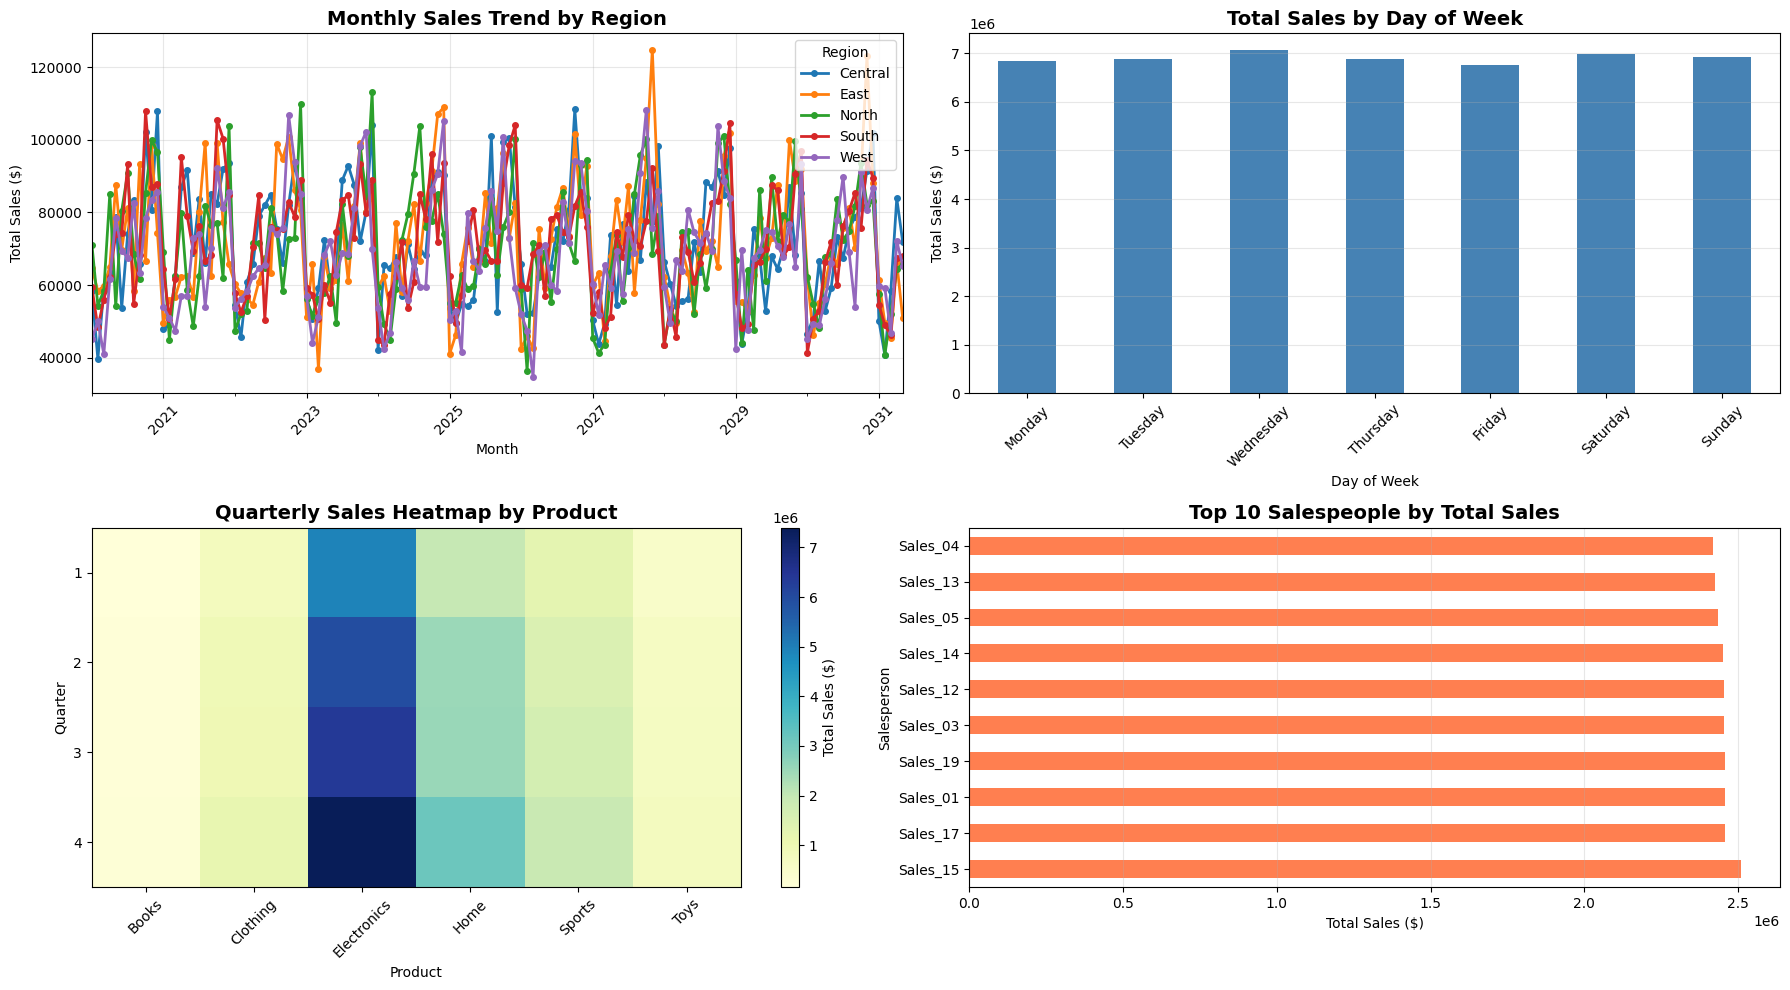

In [10]:
# Create large-scale time-series sales data (100,000 transactions)
print("=== Creating Large-Scale Sales Dataset ===")
np.random.seed(42)
n_sales = 100000

# Generate realistic sales data with trends and seasonality
start_date = pd.Timestamp("2020-01-01")
dates = pd.date_range(start_date, periods=n_sales, freq="H")[
    :n_sales
]  # Hourly data

products = ["Electronics", "Clothing", "Books", "Home", "Sports", "Toys"]
regions = ["North", "South", "East", "West", "Central"]
salespeople = [f"Sales_{i:02d}" for i in range(1, 21)]  # 20 salespeople

# Create seasonal patterns
day_of_year = dates.dayofyear
month = dates.month
day_of_week = dates.dayofweek

# Base prices with product-specific ranges
product_prices = {
    "Electronics": (100, 2000),
    "Clothing": (20, 300),
    "Books": (10, 50),
    "Home": (50, 800),
    "Sports": (30, 500),
    "Toys": (15, 200),
}

# Generate sales data with correlations
sales_data = {
    "Date": dates,
    "Product": np.random.choice(products, n_sales),
    "Region": np.random.choice(regions, n_sales),
    "Salesperson": np.random.choice(salespeople, n_sales),
}

sales_df = pd.DataFrame(sales_data)

# Generate correlated prices and quantities
unit_prices = []
quantities = []
for product in sales_df["Product"]:
    price_min, price_max = product_prices[product]
    price = np.random.uniform(price_min, price_max)
    unit_prices.append(price)
    # Higher prices tend to have lower quantities
    qty = max(
        1,
        int(
            np.random.exponential(3)
            * (1 - (price - price_min) / (price_max - price_min))
        ),
    )
    quantities.append(min(qty, 20))

sales_df["Unit_Price"] = unit_prices
sales_df["Quantity"] = quantities
sales_df["Total_Sales"] = sales_df["Quantity"] * sales_df["Unit_Price"]

# Add time-based features
sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Quarter"] = sales_df["Date"].dt.quarter
sales_df["DayOfWeek"] = sales_df["Date"].dt.day_name()
sales_df["Hour"] = sales_df["Date"].dt.hour

# Add seasonal multiplier (higher sales in Q4, lower in Q1)
seasonal_mult = sales_df["Quarter"].map({1: 0.8, 2: 1.0, 3: 1.1, 4: 1.3})
sales_df["Total_Sales"] = sales_df["Total_Sales"] * seasonal_mult

print(f"Sales dataset shape: {sales_df.shape}")
print(f"Date range: {sales_df['Date'].min()} to {sales_df['Date'].max()}")
print(
    f"Memory usage: {sales_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
)
print("\nSample sales data:")
print(sales_df.head())

# Comprehensive time-series analysis
print("\n=== Time-Series GroupBy Analysis ===")

# Monthly sales by region
monthly_sales = sales_df.groupby([
    sales_df["Date"].dt.to_period("M"),
    "Region",
])["Total_Sales"].agg(["sum", "mean", "count"])
print("\nMonthly sales summary by region:")
print(monthly_sales.head(15))

# Top salesperson by region (using apply with include_groups=False)
top_salesperson = sales_df.groupby("Region").apply(
    lambda x: x.groupby("Salesperson")["Total_Sales"].sum().idxmax(),
    include_groups=False,
)
print("\nTop salesperson by region:")
print(top_salesperson)

# Quarterly product performance
quarterly_product = sales_df.groupby(["Quarter", "Product"])["Total_Sales"].agg([
    "sum",
    "mean",
])
print("\nQuarterly product performance:")
print(quarterly_product)

# Visualize time-series patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# 1. Monthly sales trend by region
monthly_trend = (
    sales_df.groupby([sales_df["Date"].dt.to_period("M"), "Region"])[
        "Total_Sales"
    ]
    .sum()
    .unstack()
)
monthly_trend.plot(ax=axes[0, 0], marker="o", linewidth=2, markersize=4)
axes[0, 0].set_title(
    "Monthly Sales Trend by Region", fontsize=14, fontweight="bold"
)
axes[0, 0].set_ylabel("Total Sales ($)")
axes[0, 0].set_xlabel("Month")
axes[0, 0].legend(title="Region")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis="x", rotation=45)

# 2. Sales by day of week
dow_sales = sales_df.groupby("DayOfWeek")["Total_Sales"].sum()
dow_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
dow_sales = dow_sales.reindex(dow_order)
dow_sales.plot(kind="bar", ax=axes[0, 1], color="steelblue")
axes[0, 1].set_title(
    "Total Sales by Day of Week", fontsize=14, fontweight="bold"
)
axes[0, 1].set_ylabel("Total Sales ($)")
axes[0, 1].set_xlabel("Day of Week")
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].grid(axis="y", alpha=0.3)

# 3. Quarterly product performance heatmap
quarterly_pivot = (
    sales_df.groupby(["Quarter", "Product"])["Total_Sales"].sum().unstack()
)
im = axes[1, 0].imshow(quarterly_pivot.values, cmap="YlGnBu", aspect="auto")
axes[1, 0].set_xticks(range(len(quarterly_pivot.columns)))
axes[1, 0].set_yticks(range(len(quarterly_pivot.index)))
axes[1, 0].set_xticklabels(quarterly_pivot.columns, rotation=45)
axes[1, 0].set_yticklabels(quarterly_pivot.index)
axes[1, 0].set_title(
    "Quarterly Sales Heatmap by Product", fontsize=14, fontweight="bold"
)
axes[1, 0].set_xlabel("Product")
axes[1, 0].set_ylabel("Quarter")
plt.colorbar(im, ax=axes[1, 0], label="Total Sales ($)")

# 4. Top 10 salespeople performance
top_salespeople = (
    sales_df.groupby("Salesperson")["Total_Sales"].sum().nlargest(10)
)
top_salespeople.plot(kind="barh", ax=axes[1, 1], color="coral")
axes[1, 1].set_title(
    "Top 10 Salespeople by Total Sales", fontsize=14, fontweight="bold"
)
axes[1, 1].set_xlabel("Total Sales ($)")
axes[1, 1].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

### Performance Analysis

=== Performance Analysis ===


Method 1 (multiple groupby): 0.006900 seconds
Method 2 (single groupby): 0.002946 seconds
Method 3 (transform): 0.004655 seconds

Performance improvement (Method 1 → Method 2): 2.34x faster


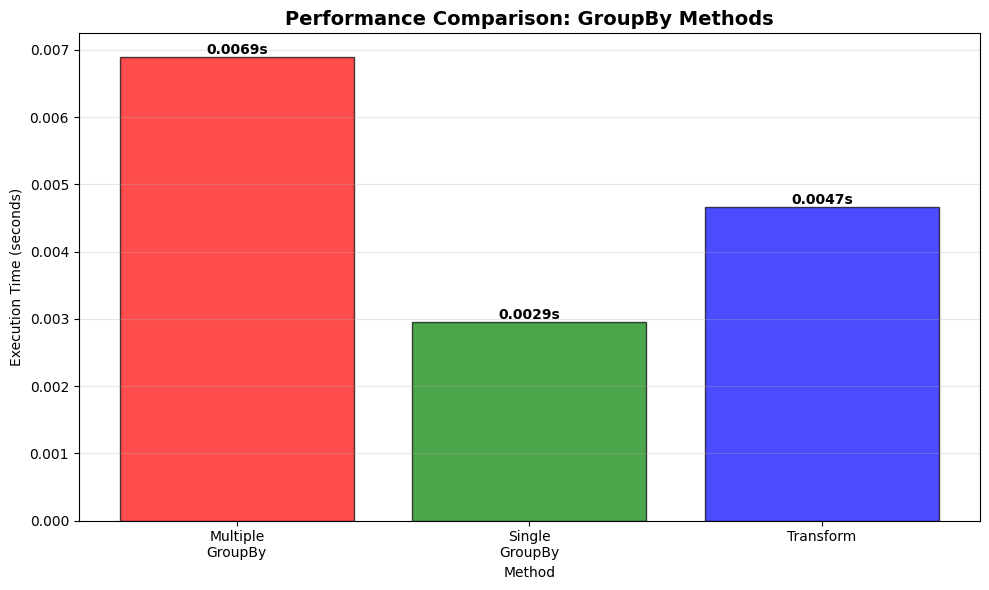

In [11]:
# Performance comparison with large dataset
print("=== Performance Analysis ===")
import time

# Method 1: Multiple groupby operations
start_time = time.time()
result1 = sales_df.groupby("Region")["Total_Sales"].sum()
result2 = sales_df.groupby("Region")["Quantity"].sum()
result3 = sales_df.groupby("Region")["Unit_Price"].mean()
method1_time = time.time() - start_time

# Method 2: Single groupby with multiple aggregations
start_time = time.time()
result4 = sales_df.groupby("Region").agg({
    "Total_Sales": "sum",
    "Quantity": "sum",
    "Unit_Price": "mean",
})
method2_time = time.time() - start_time

# Method 3: Using transform (for comparison)
start_time = time.time()
sales_df["Region_Sales_Sum"] = sales_df.groupby("Region")[
    "Total_Sales"
].transform("sum")
sales_df["Region_Qty_Sum"] = sales_df.groupby("Region")["Quantity"].transform(
    "sum"
)
method3_time = time.time() - start_time

print(f"Method 1 (multiple groupby): {method1_time:.6f} seconds")
print(f"Method 2 (single groupby): {method2_time:.6f} seconds")
print(f"Method 3 (transform): {method3_time:.6f} seconds")
print(
    f"\nPerformance improvement (Method 1 → Method 2): {method1_time / method2_time:.2f}x faster"
)

# Visualize performance comparison
fig, ax = plt.subplots(figsize=(10, 6))
methods = ["Multiple\nGroupBy", "Single\nGroupBy", "Transform"]
times = [method1_time, method2_time, method3_time]
colors = ["red", "green", "blue"]
bars = ax.bar(methods, times, color=colors, alpha=0.7, edgecolor="black")
ax.set_title(
    "Performance Comparison: GroupBy Methods", fontsize=14, fontweight="bold"
)
ax.set_ylabel("Execution Time (seconds)")
ax.set_xlabel("Method")
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{time_val:.4f}s",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Split-Apply-Combine**: The fundamental pattern of data aggregation
2. **Aggregation Functions**: Use mean, sum, count, and custom functions
3. **Transform Operations**: Add group statistics to original data
4. **Filter Operations**: Remove groups based on conditions
5. **Apply Operations**: Use custom functions on groups
6. **Hierarchical Grouping**: Work with multi-level group structures
7. **Performance**: Single groupby with multiple aggregations is more efficient

## Next Steps

- Practice with your own datasets
- Experiment with different aggregation functions
- Learn about pivot tables for multi-dimensional analysis
- Explore remote computing for large datasets